In [1]:
import torch

In [2]:
import numpy as np
import pandas as pd

In [4]:
# print all columns
pd.set_option('display.max_columns', None)

In [3]:
#import torchvision

In [3]:
#import timm

In [3]:
# import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt

In [5]:
import os

In [7]:
from scipy.interpolate import CubicSpline

In [8]:
# try to redo timedelta with time
from datetime import datetime

In [246]:
from copy import deepcopy

In [329]:
from random import choice, shuffle

Load trajectory

In [9]:
BASE_PATH = '/Volumes/Experiment Data/Sasha and Or/'

Variables

In [11]:
# list of participants - ignore hidden files/folders (.DS_Store)
part_set = set([_dir for _dir in os.listdir(BASE_PATH) if not _dir.startswith(".")])

In [12]:
len(part_set)

38

In [13]:
exclude_set = set(['DL','OL','SM'])

In [14]:
PART_LIST = list(part_set - exclude_set)

In [15]:
len(PART_LIST)

35

In [16]:
# 125 hz
FREQ = 0.008

In [438]:
START_DELTA = 0.0 
# first 100 stimuli * 3 seconds each
# timedelta starts with 0 st second 300 is the right edge
# add one more time bracket for interpolation before trimming
END_DELTA = 300.0 
END_MINUTE = 5

In [307]:
GAZE_COLS = ['norm_pos_x','norm_pos_y']

In [422]:
# Guess
# HEAD_COLS = ['Time',	'headx',	'heady',	'headz',	'head rot x',	head rot y	head rot z	head_dir_x	head_dir_y	head_dir_z]
HEAD_COLS = ['head rot x','head rot y','head rot z','head_dir_x','head_dir_y','head_dir_z','head_right_x','head_right_y','head_right_z','head_up_x','head_up_y','head_up_z']

Helper functions

In [354]:
# given a time-segmented sample, removes the mean from each time series column
def zero_center(df,return_cols=None):
    def zero_center_series(series):
        # nan_series = pd.Series(dtype=series.dtype).reindex_like(series)
        return series - np.mean(series)
    
    if type(df) is pd.Series: return zero_center_series(df)
    
    return_cols = return_cols if return_cols is not None else df.columns
    norm_df = pd.DataFrame().reindex_like(df[return_cols])
    
    for col in norm_df.columns:
        norm_df[col] = zero_center_series(df[col])
        
    return norm_df 

In [424]:
def fillfirstna(resampled_df,orig_df):
    # gaze_sample.loc[ar_gaze_sample['timedelta']>0].index[0] should be equivalent to ar_gaze_sample.iloc[0] if reset index to start_delta ie timedelta >=0
    if resampled_df.iloc[0].isna().all() and orig_df.iloc[0]['timedelta'] >= START_DELTA:
            resampled_df.iloc[0] = orig_df.iloc[0][resampled_df.columns]
    # TODO elif second clause make more flex for closest in time
    return resampled_df


def resample_and_interpolate(df,interp_cols,ffill=False,linear=True,hz=FREQ):
    
    # 100 sample session ends at 6 minutes
    end = datetime(year=1970,month=1,day=1,minute=END_MINUTE,second=0)
    interp_cols = interp_cols.copy()
    # mod ffill method to only return resampled time points 
    if ffill:
        resampled_df = df.set_index('timedelta_dt').resample('{hz}S'.format(hz=hz)).ffill()
        df = df.set_index('timedelta_dt')
        # if no data at the 0th time mark, will be na because ffill 
        # fill onset gaze loc with "original" (closest) value 
        resampled_df = fillfirstna(resampled_df,df)
        # resampledInterspersed_df = resampledCat_df.sort_values(by='timedelta_dt')
        # resampled_df = resampled_df[(resampled_df.index.minute <= END_MINUTE)]
        resampled_df = resampled_df[(resampled_df.index <= end)][interp_cols]
        
    elif linear:
        # returns empty dataframe indexed at frequency
        NaNresampled_df = df.set_index('timedelta_dt').resample('{hz}S'.format(hz=hz)).interpolate()
        df = df.set_index('timedelta_dt')
        # should be zero overlap between timestamps since original report is to nanosecond and resampling is by the millisecond
        # concats back-to-back
        resampledCat_df = pd.concat([NaNresampled_df,df])
        # order by time - nan rows interspersed with reported values
        resampledInterspersed_df = resampledCat_df.sort_values(by='timedelta_dt')
        # (Linear) interpolation between resampled points
        linInterp_df = resampledInterspersed_df[interp_cols].interpolate(method='linear')
        # linInterp_df = resampledInterspersed_df.interpolate(method='linear')
        
        # take only the resampled time rows
        resampled_df = linInterp_df.loc[NaNresampled_df.index]
        
        resampled_df = fillfirstna(resampled_df,df)
        
        # resampled_df = resampled_df[resampled_df.index.minute < END_MINUTE]
        # keep right fencepost
        resampled_df = resampled_df[(resampled_df.index <= end)]
        
    # cubic spline interpolation
    else:
        # returns empty dataframe indexed at frequency
        NaNresampled_df = df.set_index('timedelta_dt').resample('{hz}S'.format(hz=hz)).interpolate()
        df = df.set_index('timedelta_dt')
        # should be zero overlap between timestamps since original report is to nanosecond and resampling is by the millisecond
        # concats back-to-back
        resampledCat_df = pd.concat([NaNresampled_df,df])
        # order by time - nan rows interspersed with reported values
        resampledInterspersed_df = resampledCat_df.sort_values(by='timedelta_dt')
        # (Cubic spline) interpolation between resampled points
        CSresampled_df = resampledInterspersed_df[interp_cols].interpolate(method='cubicspline')
        
        # take only the resampled time rows
        resampled_df = CSresampled_df.loc[NaNresampled_df.index]
        
        resampled_df = fillfirstna(resampled_df,df)
        
        # resampled_df = resampled_df[resampled_df.index.minute < END_MINUTE]
        # keep right fencepost
        resampled_df = resampled_df[(resampled_df.index <= end)]
        
    return resampled_df 

def input_tensor(df,return_cols=None):
    return_cols = df.columns if not return_cols else return_cols
    resampled_df = resample_and_interpolate(df,interp_cols=return_cols,linear=True)
    centered_df = zero_center(resampled_df)
    return torch.tensor(centered_df.values)

Load data functions

In [432]:
def load_events(part):
    events_path = BASE_PATH+part+'/Events.csv'
    _events_df = pd.read_csv(events_path,on_bad_lines='warn')
    
    simset = int(_events_df.columns[1].split('_')[1])
    
    imgs = np.array([int(_events_df.loc[img][0]) for img in _events_df.index])
    
    _events = pd.Series([event[0] for event in _events_df.index],name='unity_time')
    # unity time
    events = _events.apply(lambda x:x/1E7) 
    
    _onsets = events.copy()
    
    # time from start as datetime
    _onsets -= _onsets[0]
    onsets = pd.to_datetime(_onsets,unit='s')
    # first line contains a timestamp but no "Looking" tag or eye data - ignore?
    #_events_onsets.insert(0,int(_events_df.columns[0]))
    
    # print(str(len(_imgs)),'stimuli,',str(len(_onsets)),'events onsets' ,'- participant',part)
    # load only the first 100
    return events[:100], onsets[:100], simset, imgs[:100]

columns - 
['confidence', 'GazeDirection_x', 'GazeDirection_y', 'GazeDirection_z',
       'GazeDistance', 'timestamp', 'norm_pos_x', 'norm_pos_y', 'EyeCenter0_x',
       'EyeCenter0_y', 'EyeCenter0_z', 'GazeNormal0_x', 'GazeNormal0_y',
       'GazeNormal0_z', 'EyeCenter1_x', 'EyeCenter1_y', 'EyeCenter1_z',
       'GazeNormal1_x', 'GazeNormal1_y', 'GazeNormal1_z', 'eyes_dir_hit_x',
       'eyes_dir_hit_y', 'eyes_dir_hit_z', 'eyes_to_surface_distance',
       'eyes_to_surface_angle', 'eyes_dir_name', 'unity_time',
       'TimeSinceStart', 'EyeID', 'Unnamed: 29']

In [19]:
# As per ofer rec to Sasha. R<>Sasha meet 7.6.22
# GAZE_COLS = ['confidence', 'norm_pos_x', 'norm_pos_y', 'timestamp','unity_time', 'TimeSinceStart']

In [261]:
def load_binocular(part,events,cols=None):
    events_path = BASE_PATH+part+'/Gaze data.csv'
    
    _cols = cols if cols else GAZE_COLS.copy()
    _cols.extend(['EyeID','unity_time'])
    _cols = list(set(_cols))
    
    _gaze_df = pd.read_csv(events_path,on_bad_lines='warn',usecols=_cols)
    
    
    
    # if it is heavy on the loading, usecols
    BINgaze_df = _gaze_df[_gaze_df['EyeID']=='Binocular'][_cols]
    BINgaze_df['unity_time'] = BINgaze_df['unity_time'].apply(lambda x: x/1E7)
        
    # time since the Beginning in unity-time seconds
    # unity time associates gaze data in Gaze data.csv with events onsets in Events.csv
    BINgaze_df['timedelta'] = BINgaze_df['unity_time'] - events[0]
    
    # cast as datetime for resampling, interpolation
    # "pre 1970" is negative time, time before first event onset
    BINgaze_df['timedelta_dt'] = pd.to_datetime(BINgaze_df['timedelta'],unit='s')
    # first data point from onset 
    # start_delta = 0.0
    BINgaze_df = BINgaze_df[BINgaze_df['timedelta'] >= START_DELTA ]
    BINgaze_df = BINgaze_df.reset_index(drop=True)
    
    return BINgaze_df

In [293]:
def load_head(part,events,cols=None):
    head_path = BASE_PATH+part+'/position.csv'
    
    _cols = cols if cols else HEAD_COLS.copy()
    _cols.extend(['Time'])
    _cols = list(set(_cols))
    # if 'Time' not in _cols:
    #     # print('Adding time to columns requested,',cols)
    #     _cols.append('Time')
    #     # print(_cols)
        
    head_df = pd.read_csv(head_path,on_bad_lines='warn',usecols=_cols)

    # take intersection of head direction and gaze data?
    head_df['unity_time'] = head_df['Time'].apply(lambda x: x/1E7) 
    head_df['timedelta'] = head_df['unity_time'] - events[0]
    head_df['timedelta_dt'] = pd.to_datetime(head_df['timedelta'],unit='s')
    
    head_df = head_df[head_df['timedelta'] >= START_DELTA ]
    head_df = head_df.reset_index(drop=True)
    return head_df

In [ ]:
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
# keeps one participant's gaze and data in memory at a time
class Dataset(torch.utils.data.Dataset):
  # 'Characterizes a dataset for PyTorch'
    def __init__(self, participantIDs=PART_LIST,gaze_cols=GAZE_COLS,head_cols=HEAD_COLS,freq=FREQ,path=BASE_PATH):
        self.part_list = participantIDs
        # self.labels = labels
        # self.list_IDs = list_IDs
        
        self.BASE_PATH = path
        
        self.GAZE_COLS = gaze_cols 
        self.HEAD_COLS = head_cols 
        self.FREQ = freq
        
        self.events_series,self.offset_dt, self.simset, self.imgsetIDs_arr = None,None,None,None
        self.imgsetIDs_copy = None
        self.img0 = -1 
        self.random_shuffle = list(range(0,100))
        shuffle(self.random_shuffle)
        
        self.traj_df = None
        # self.gaze_df = None
        # self.head_df = None
        
        self.part_pointer = 0
        self.sample_pointer = -1 
        
        (self.imgset, self.imgset_labels), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    def decode_image_from_simset_and_label(simset=self.simset,label):
        return self.imgset[np.where(self.imgset_labels==label)[0][simset-1]]
        
    def __len__(self):
        # 'Denotes the total number of samples'
        # return len(self.list_IDs)
        return 100 * len(self.part_list)

    def __getitem__(self, index):
        # 'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        
        if self.sample_pointer >= 99:
            self.part_pointer += 1
            self.sample_pointer = -1
        
        if self.sample_pointer < 0:
            part = self.part_list[self.part_pointer]
            # convert events series in unity_time to datetime
            self.events_series, self.offset_dt, self.simset, self.imgs_arr = load_events(part)
            
            #Load df, linearly interpolate at resampled time periods,
            gaze_df = resample_and_interpolate(load_binocular(part=part,events=self.events_series),linear=True,interp_cols=self.GAZE_COLS.copy(),hz=self.FREQ)
            head_df = resample_and_interpolate(load_head(part=part,events=self.events_series),linear=True,interp_cols=self.HEAD_COLS.copy(),hz=self.FREQ)
            # join on shared, resampled timedelta_dt index
            self.traj_df = gaze_df.join(head_df)
            
            # save the first image for the last mutual set 
            self.img0 = self.imgsetIDs_arr[self.random_shuffle[0]]
            
        self.sample_pointer += 1
        # iterate over img Ids 
        jointImg_id = self.imgsetIDs_arr[self.random_shuffle[self.sample_pointer]]
        joint_img = self.decode_img_from_simset_and_labels(label=jointImg_id)
        joint_tens = torch.tensor(joint_img.values)
        # select an alternative image ID from the participant's simset
        self.imgsetIDs_copy.remove(jointImgs_id)
        
        # if it is the last img (and )
        mutualImg_id = choice(self.imgsetIDs_copy) if self.sample_pointer < 99 else self.img0
        mutual_img = self.decode_img_from_simset_and_labels(label=mutualImg_id)
        mutual_tens = torch.tensor(mutual_img.value)
        
        start_event = self.offset_dt[self.random_shuffle[self.sample_pointer]] + pd.Timedelta(seconds=0.5)
        # dataset is prefenceposted 
        end_event = self.offset_dt[self.random_shuffle[self.sample_pointer] + 1]  
        
        traj = self.traj_df[(self.traj_df.index >= start_event) & (self.traj_df.index < end_event)]
        traj_tens = torch.tensor(traj.values)

        # return tuple of (trajectory, joint img, random img)
        # batch is a tuple of (joint1, joint2, marginal (from the dataset of joint 2)) - MINE.py
        return (traj_tens,joint_tens,mutual_tens)

In [126]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [127]:
def decode_image_from_simset_and_label(simset,label):
    return x_train[np.where(y_train==label)[0][simset-1]]

In [128]:
img = decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[0])

In [129]:
img.shape

(32, 32, 3)

In [130]:
torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1])).shape

torch.Size([32, 32, 3])

In [17]:
# events_dict = {}
# for part in PART_LIST:
    # try:
    #     onsets, simset, imgs = load_events(part)
    #     events_dict[part+'_events'] = onsets
    #     events_dict[part+'_simset'] = simset
    #     events_dict[part+'_imgs'] = imgs
    # except FileNotFoundError as e:
    #     print(e)

122 stimuli, 122 events onsets - participant AR
122 stimuli, 122 events onsets - participant DI
122 stimuli, 122 events onsets - participant DM
122 stimuli, 122 events onsets - participant IL
122 stimuli, 122 events onsets - participant IS
122 stimuli, 122 events onsets - participant MA
122 stimuli, 122 events onsets - participant NC
122 stimuli, 122 events onsets - participant NCH
122 stimuli, 122 events onsets - participant NH
122 stimuli, 122 events onsets - participant NT
124 stimuli, 124 events onsets - participant OA
122 stimuli, 122 events onsets - participant OB
122 stimuli, 122 events onsets - participant RB
122 stimuli, 122 events onsets - participant RN
122 stimuli, 122 events onsets - participant SG
122 stimuli, 122 events onsets - participant SHB
122 stimuli, 122 events onsets - participant SHM
122 stimuli, 122 events onsets - participant SSW
122 stimuli, 122 events onsets - participant TL
122 stimuli, 122 events onsets - participant VT
122 stimuli, 122 events onsets - par

In [131]:
imgs = torch.stack([torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[:5])),torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1]))])

In [132]:
imgs.shape

torch.Size([2, 32, 32, 3])

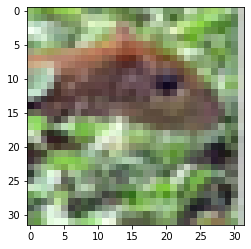

In [133]:
plt.imshow(img)

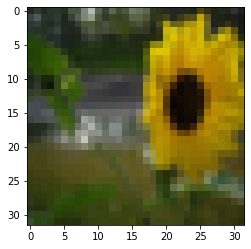

In [134]:
plt.imshow(imgs[1])

In [20]:
cifar_vit = timm.create_model('vit_base_patch16_224_miil_in21k', pretrained=True)

In [137]:
# cifar_vit.eval()

In [136]:
# from pprint import pprint
# model_names = timm.list_models(pretrained=True)
# pprint(model_names)

--------------------
Resample method story
--------------------

In [29]:
ar_gaze_resampled = resample_and_interpolate(ar_gaze_df)

In [124]:
ar_gaze_linear = resample_and_interpolate(ar_gaze_df,linear=True)

In [125]:
ar_gaze_linear.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,0.603335,-0.251901
1970-01-01 00:00:00.008,0.605967,-0.250007
1970-01-01 00:00:00.016,0.605783,-0.252272
1970-01-01 00:00:00.024,0.605598,-0.254537
1970-01-01 00:00:00.032,0.597065,-0.248331


In [126]:
ar_gaze_linear.tail()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:05:59.968,0.552567,-0.170341
1970-01-01 00:05:59.976,0.551414,-0.159193
1970-01-01 00:05:59.984,0.551106,-0.174616
1970-01-01 00:05:59.992,0.553333,-0.194982
1970-01-01 00:06:00.000,0.555561,-0.215349


In [101]:
ar_gaze_ffill= resample_and_interpolate(ar_gaze_df,ffill=True)

In [102]:
ar_gaze_ffill.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta
timedelta_dt,,,,,,,
1970-01-01 00:00:00.000,1.00000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034
1970-01-01 00:00:00.008,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.016,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.024,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.032,1.00000,0.597524,-0.247967,152.904038,4014.660050,153.0056,0.028954


In [105]:
ar_gaze_ffill.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta
timedelta_dt,,,,,,,
1970-01-01 00:00:00.000,1.00000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034
1970-01-01 00:00:00.008,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.016,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.024,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075
1970-01-01 00:00:00.032,1.00000,0.597524,-0.247967,152.904038,4014.660050,153.0056,0.028954


In [53]:
ar_gaze_resampled.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,0.603335,-0.251901
1970-01-01 00:00:00.008,1.075943,0.005425
1970-01-01 00:00:00.016,1.408222,-0.321605
1970-01-01 00:00:00.024,1.174222,-0.532017
1970-01-01 00:00:00.032,-0.170017,0.106299


In [54]:
ar_gaze_resampled.index.second

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            59, 59, 59, 59, 59, 59, 59, 59, 59,  0],
           dtype='int64', name='timedelta_dt', length=45001)

In [30]:
ar_gaze_df.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
0,1.00000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034,1970-01-01 00:00:00.001033900
1,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075,1970-01-01 00:00:00.001075300
2,0.94489,0.605414,-0.256802,152.890226,4014.659948,153.0055,0.028852,1970-01-01 00:00:00.028852399
3,1.00000,0.601761,-0.253033,152.892312,4014.659989,153.0055,0.028893,1970-01-01 00:00:00.028893199
4,1.00000,0.603854,-0.251132,152.896237,4014.660020,153.0056,0.028924,1970-01-01 00:00:00.028924100


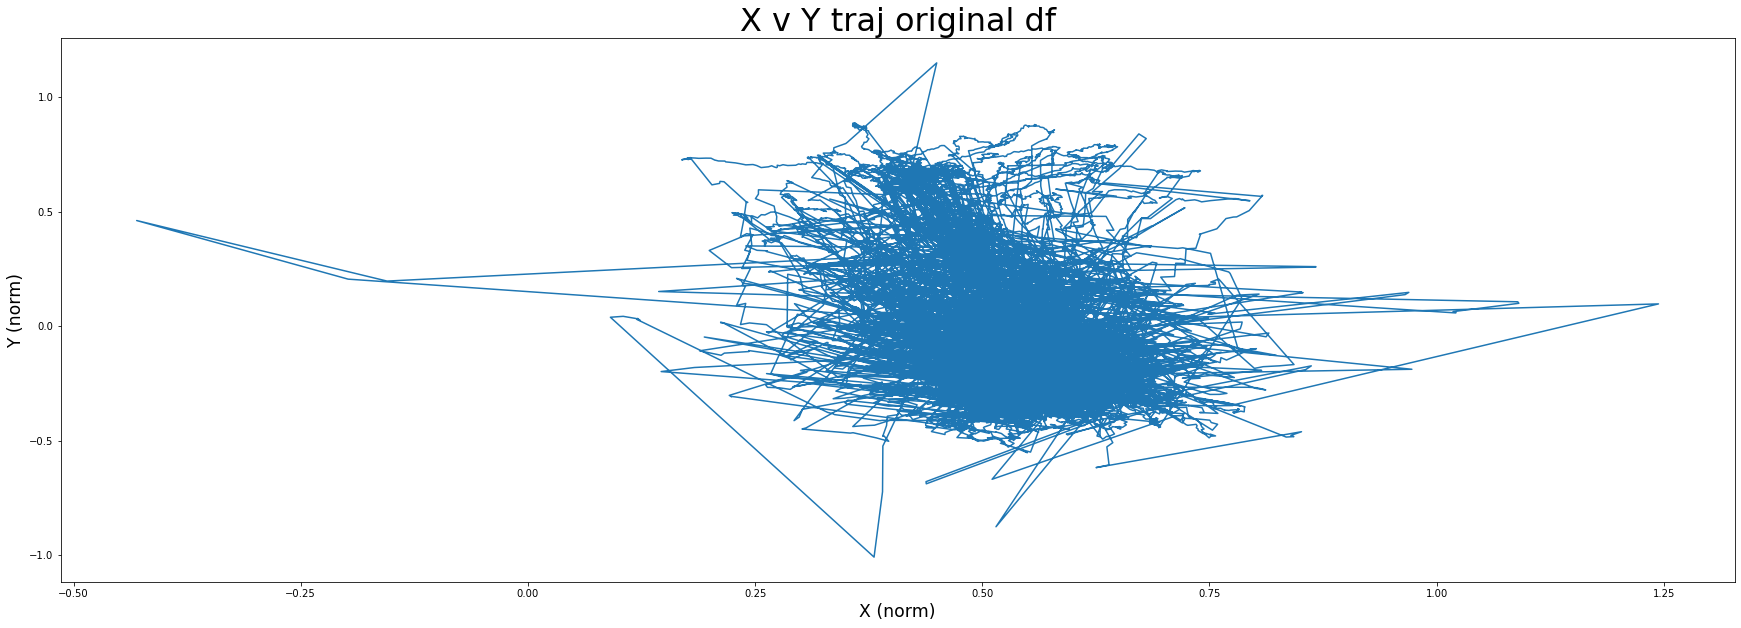

In [40]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ar_gaze_df['norm_pos_x'],ar_gaze_df['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj original df',fontsize=32)
plt.tick_params()
plt.show()

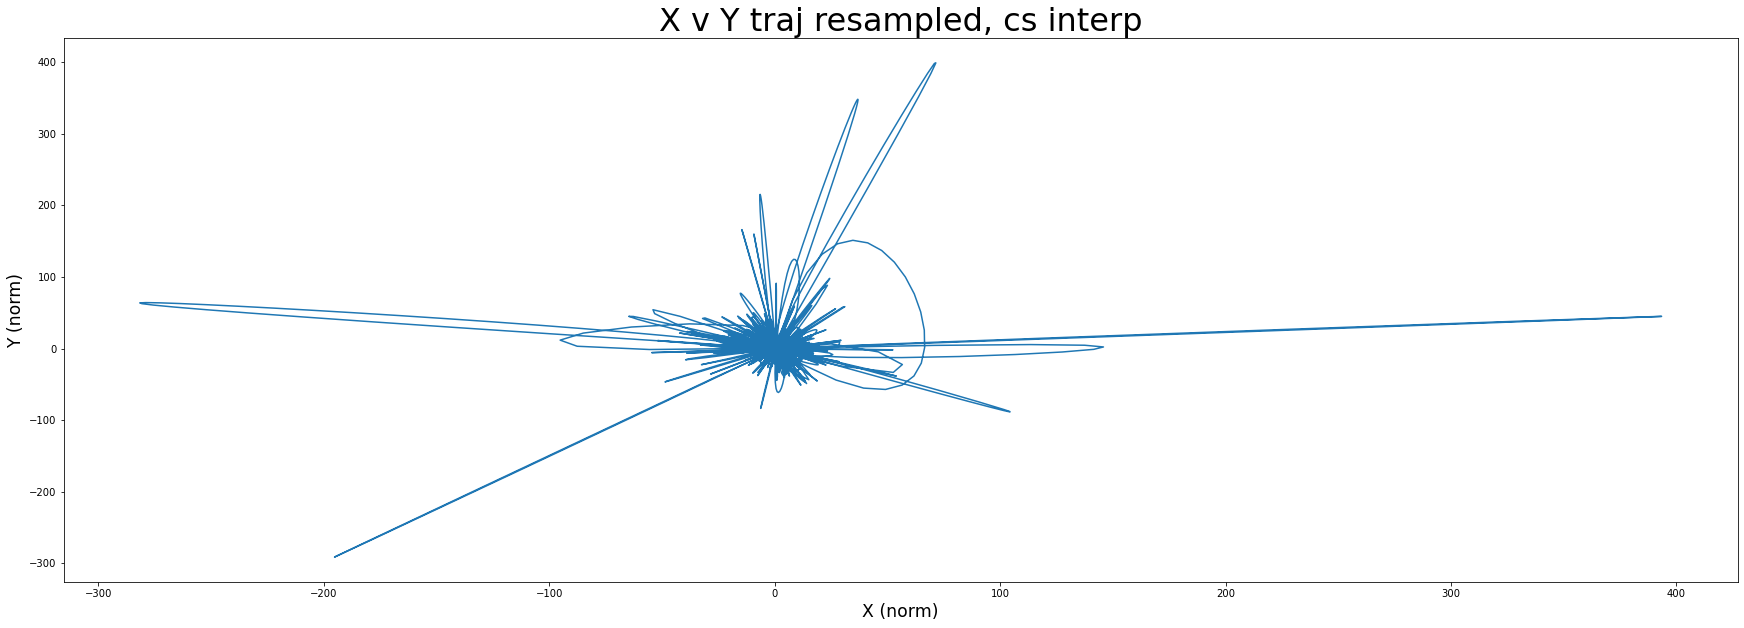

In [41]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ar_gaze_resampled['norm_pos_x'],ar_gaze_resampled['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj resampled, cs interp',fontsize=32)
plt.tick_params()
plt.show()

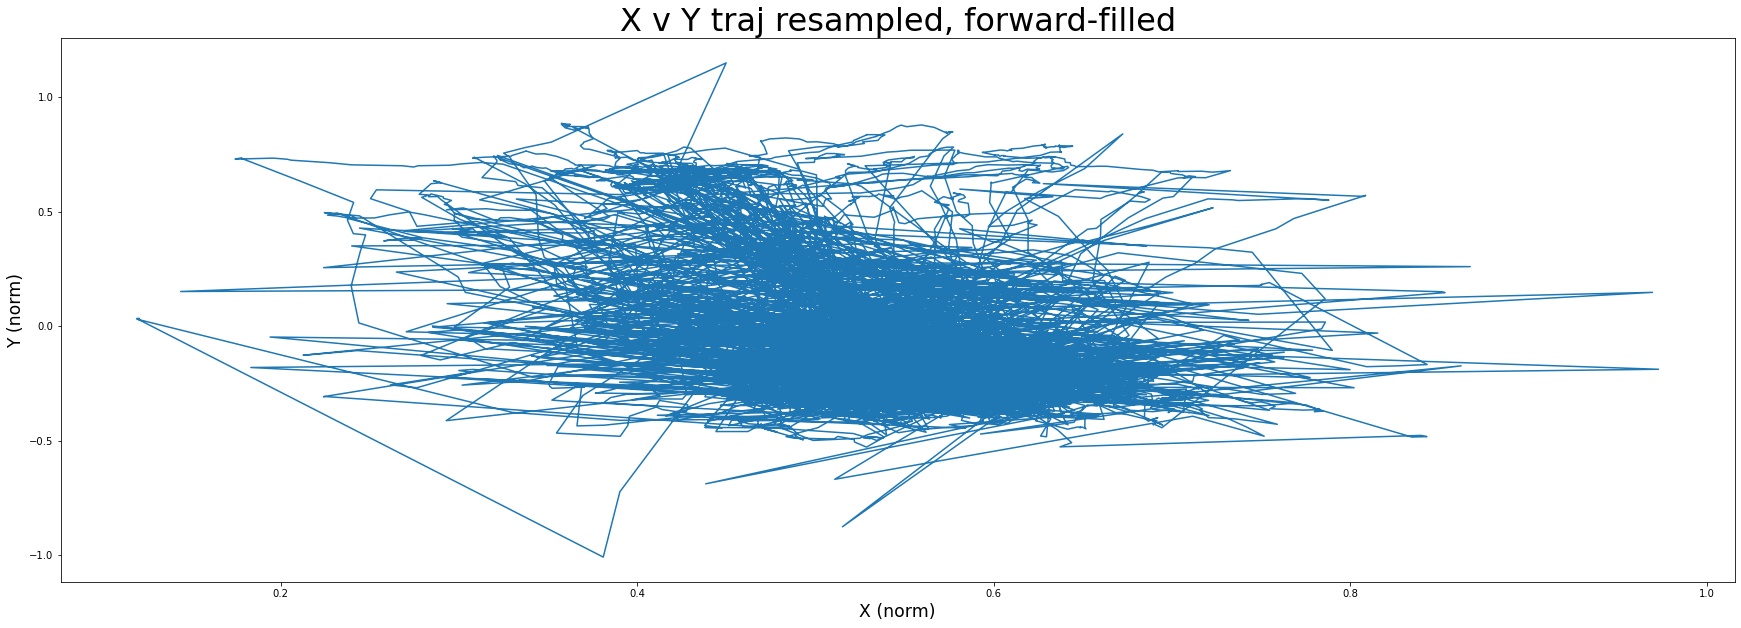

In [106]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ar_gaze_ffill['norm_pos_x'],ar_gaze_ffill['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj resampled, forward-filled',fontsize=32)
plt.tick_params()
plt.show()

In [47]:
len(ar_gaze_df)

49650

In [51]:
ar_events_series[1]

4017.6564507

In [82]:
second_slice = ar_gaze_df[(ar_gaze_df['unity_time'] >= ar_events_series[1]) & (ar_gaze_df['unity_time'] < ar_events_series[2])]

In [84]:
second_slice['timedelta_dt']

450   1970-01-01 00:00:03.085033199
451   1970-01-01 00:00:03.085066600
452   1970-01-01 00:00:03.085125300
453   1970-01-01 00:00:03.085157200
454   1970-01-01 00:00:03.093753099
                   ...             
878   1970-01-01 00:00:06.020877299
879   1970-01-01 00:00:06.020907600
880   1970-01-01 00:00:06.020952699
881   1970-01-01 00:00:06.020998800
882   1970-01-01 00:00:06.030891999
Name: timedelta_dt, Length: 433, dtype: datetime64[ns]

In [85]:
resecond_slice = ar_gaze_resampled[(ar_gaze_resampled.index >= second_slice['timedelta_dt'].iloc[0]) & (ar_gaze_resampled.index <= second_slice['timedelta_dt'].iloc[-1])]

In [86]:
resecond_slice.index

DatetimeIndex(['1970-01-01 00:00:03.088000', '1970-01-01 00:00:03.096000',
               '1970-01-01 00:00:03.104000', '1970-01-01 00:00:03.112000',
               '1970-01-01 00:00:03.120000', '1970-01-01 00:00:03.128000',
               '1970-01-01 00:00:03.136000', '1970-01-01 00:00:03.144000',
               '1970-01-01 00:00:03.152000', '1970-01-01 00:00:03.160000',
               ...
               '1970-01-01 00:00:05.952000', '1970-01-01 00:00:05.960000',
               '1970-01-01 00:00:05.968000', '1970-01-01 00:00:05.976000',
               '1970-01-01 00:00:05.984000', '1970-01-01 00:00:05.992000',
                      '1970-01-01 00:00:06', '1970-01-01 00:00:06.008000',
               '1970-01-01 00:00:06.016000', '1970-01-01 00:00:06.024000'],
              dtype='datetime64[ns]', name='timedelta_dt', length=368, freq=None)

In [111]:
ffill_slice = ar_gaze_ffill[(ar_gaze_ffill.index >= resecond_slice.index[0]) & (ar_gaze_ffill.index <= resecond_slice.index[-1])]

In [112]:
ffill_slice.index

DatetimeIndex(['1970-01-01 00:00:03.088000', '1970-01-01 00:00:03.096000',
               '1970-01-01 00:00:03.104000', '1970-01-01 00:00:03.112000',
               '1970-01-01 00:00:03.120000', '1970-01-01 00:00:03.128000',
               '1970-01-01 00:00:03.136000', '1970-01-01 00:00:03.144000',
               '1970-01-01 00:00:03.152000', '1970-01-01 00:00:03.160000',
               ...
               '1970-01-01 00:00:05.952000', '1970-01-01 00:00:05.960000',
               '1970-01-01 00:00:05.968000', '1970-01-01 00:00:05.976000',
               '1970-01-01 00:00:05.984000', '1970-01-01 00:00:05.992000',
                      '1970-01-01 00:00:06', '1970-01-01 00:00:06.008000',
               '1970-01-01 00:00:06.016000', '1970-01-01 00:00:06.024000'],
              dtype='datetime64[ns]', name='timedelta_dt', length=368, freq=None)

In [127]:
linear_slice = ar_gaze_linear[(ar_gaze_linear.index >= second_slice['timedelta_dt'].iloc[0]) & (ar_gaze_linear.index <= second_slice['timedelta_dt'].iloc[-1])]

In [128]:
linear_slice.index

DatetimeIndex(['1970-01-01 00:00:03.088000', '1970-01-01 00:00:03.096000',
               '1970-01-01 00:00:03.104000', '1970-01-01 00:00:03.112000',
               '1970-01-01 00:00:03.120000', '1970-01-01 00:00:03.128000',
               '1970-01-01 00:00:03.136000', '1970-01-01 00:00:03.144000',
               '1970-01-01 00:00:03.152000', '1970-01-01 00:00:03.160000',
               ...
               '1970-01-01 00:00:05.952000', '1970-01-01 00:00:05.960000',
               '1970-01-01 00:00:05.968000', '1970-01-01 00:00:05.976000',
               '1970-01-01 00:00:05.984000', '1970-01-01 00:00:05.992000',
                      '1970-01-01 00:00:06', '1970-01-01 00:00:06.008000',
               '1970-01-01 00:00:06.016000', '1970-01-01 00:00:06.024000'],
              dtype='datetime64[ns]', name='timedelta_dt', length=368, freq=None)

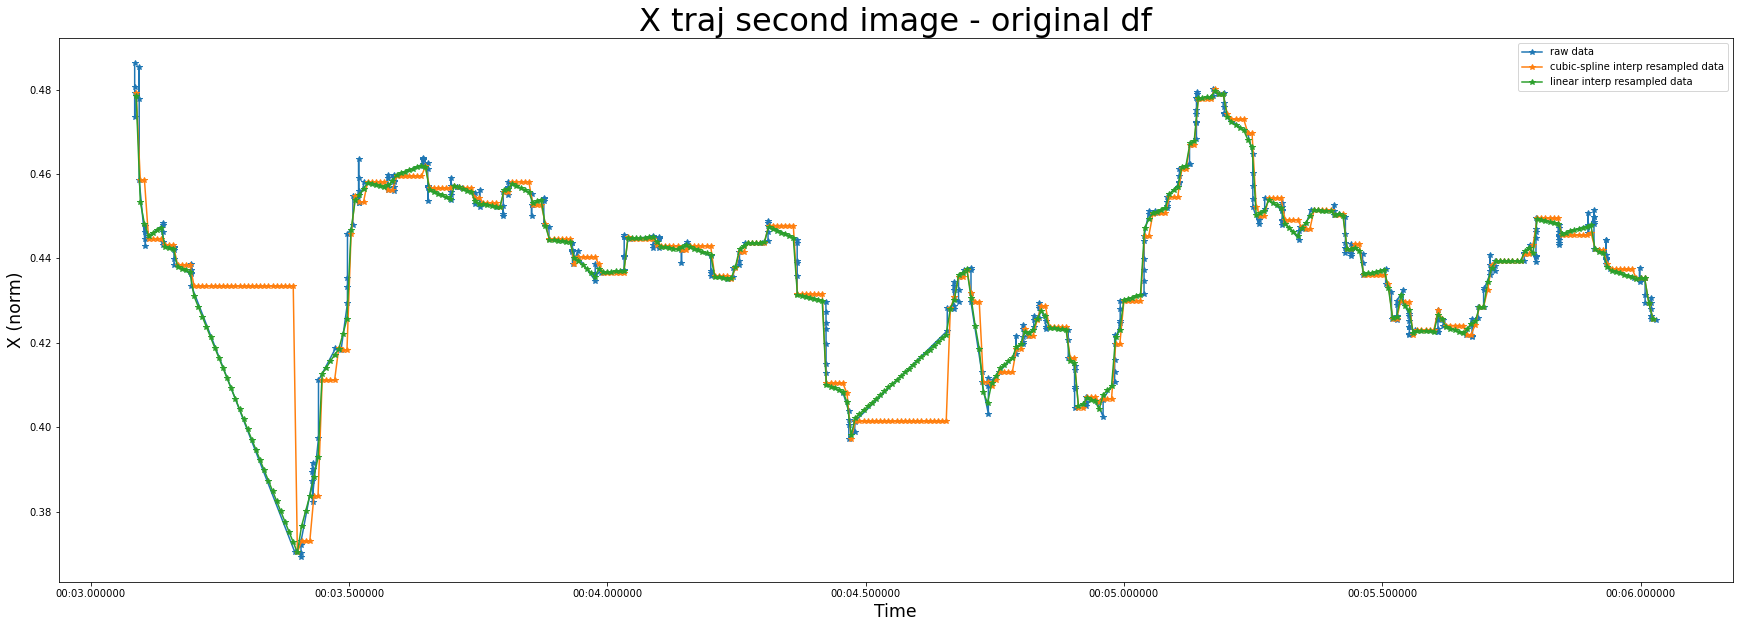

In [131]:
fig, ax = plt.subplots(figsize=(30,10),)
ax.plot(second_slice['timedelta_dt'],second_slice['norm_pos_x'],'*-')
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('X (norm)',fontsize='xx-large')
plt.title('X traj second image - original df',fontsize=32)

# ax.plot(resecond_slice.index,resecond_slice['norm_pos_x'],'*-')

ax.plot(ffill_slice.index,ffill_slice['norm_pos_x'],'*-')
ax.plot(linear_slice.index,linear_slice['norm_pos_x'],'*-')

ax.legend(['raw data','cubic-spline interp resampled data','linear interp resampled data'])
plt.tick_params()
plt.show()


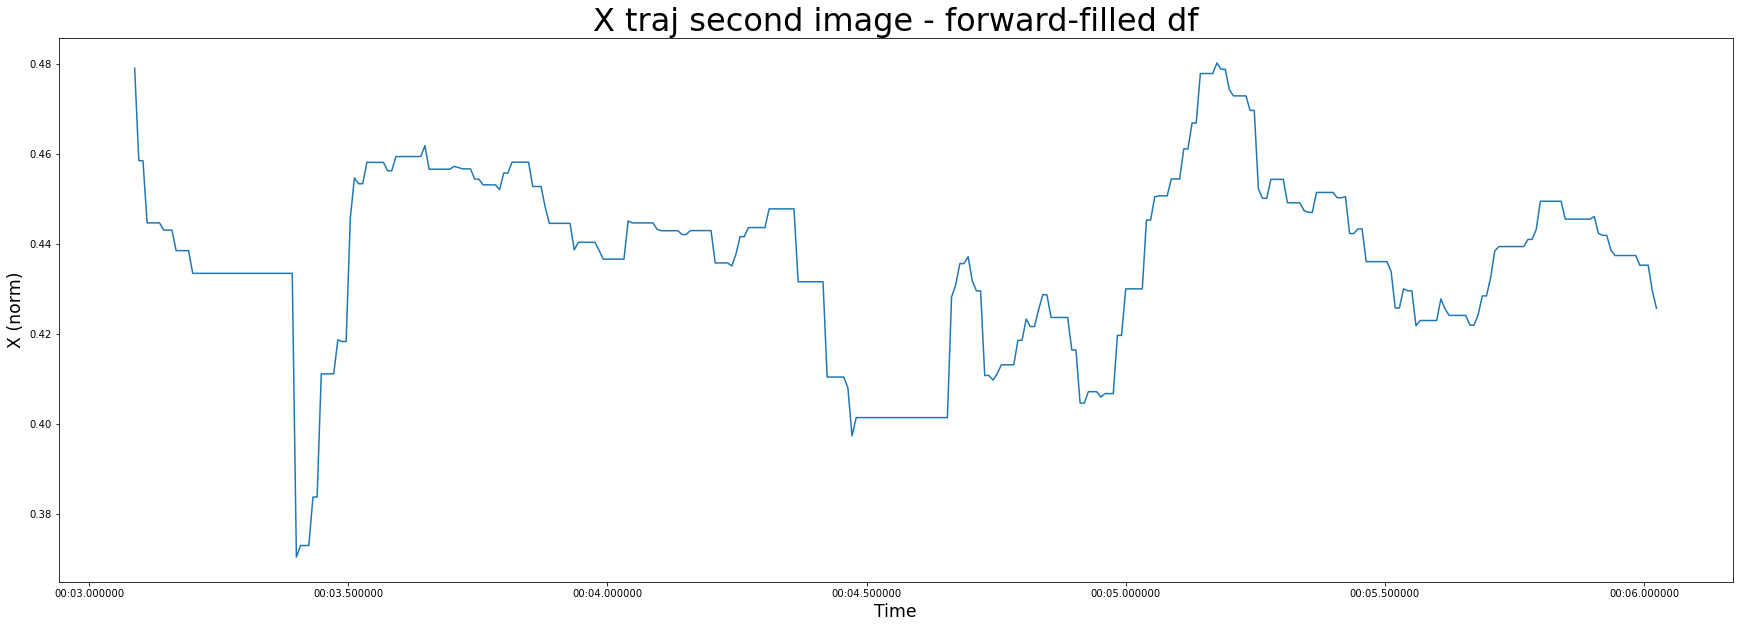

In [114]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ffill_slice.index,ffill_slice['norm_pos_x'])
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('X (norm)',fontsize='xx-large')
plt.title('X traj second image - forward-filled df',fontsize=32)
plt.tick_params()
plt.show()

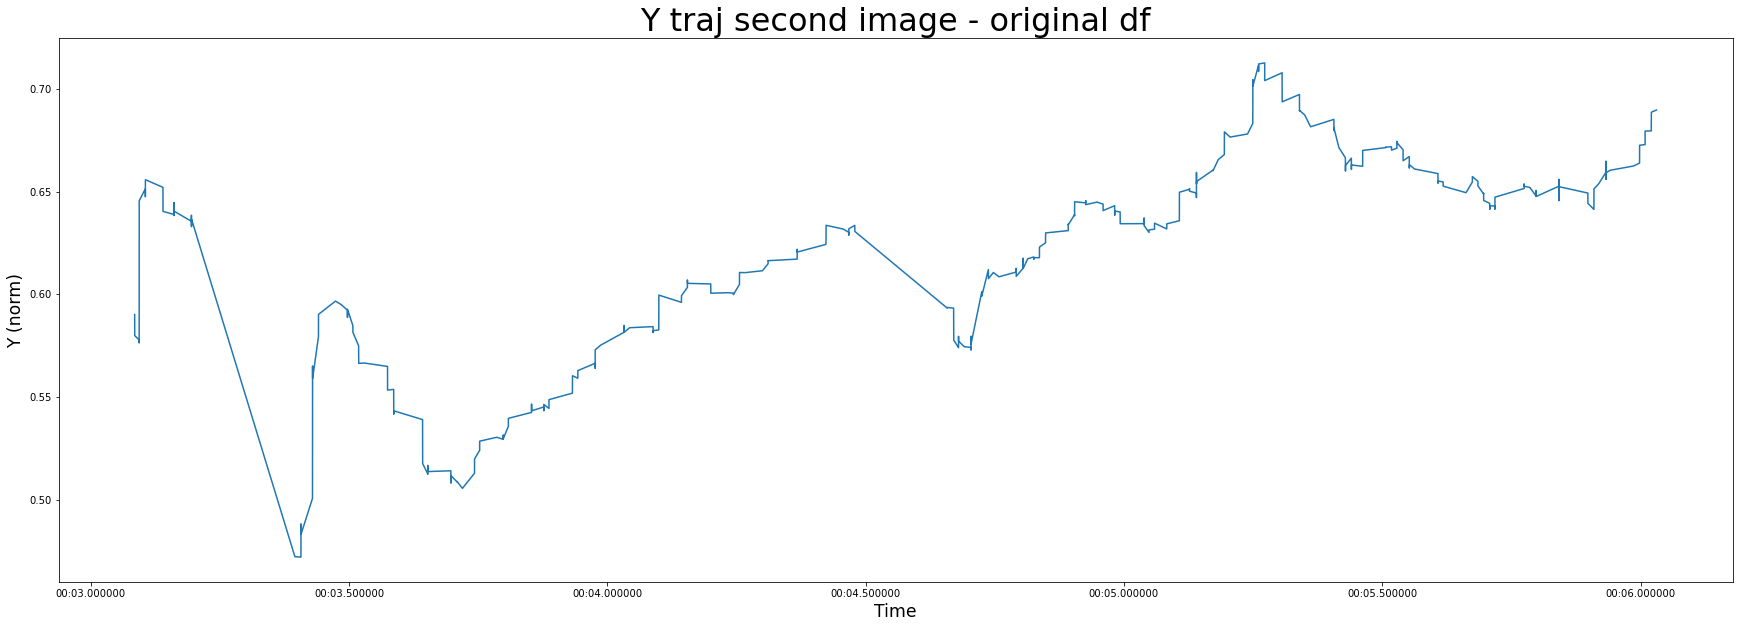

In [74]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(second_slice['timedelta_dt'],second_slice['norm_pos_y'])
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('Y traj second image - original df',fontsize=32)
plt.tick_params()
plt.show()

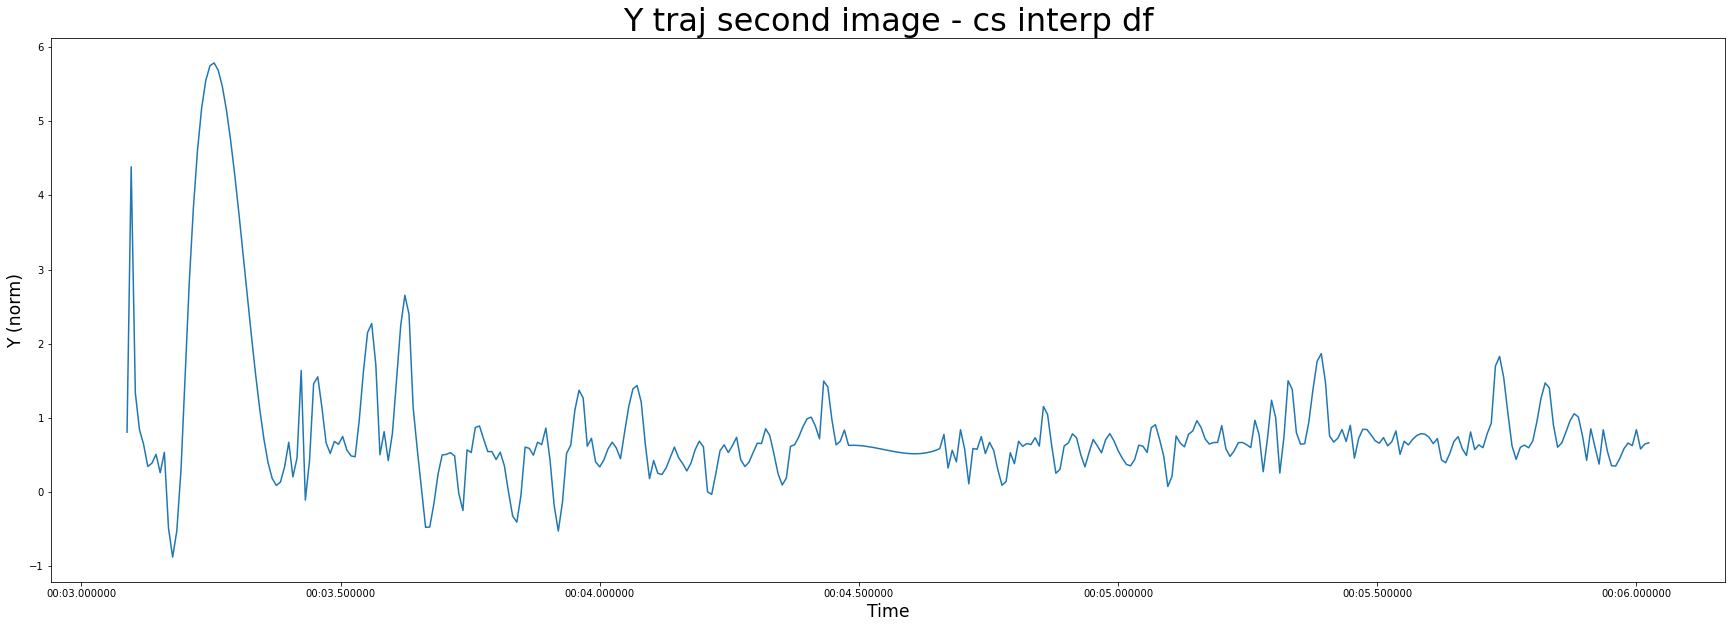

In [75]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(resecond_slice.index,resecond_slice['norm_pos_y'])
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('Y traj second image - cs interp df',fontsize=32)
plt.tick_params()
plt.show()

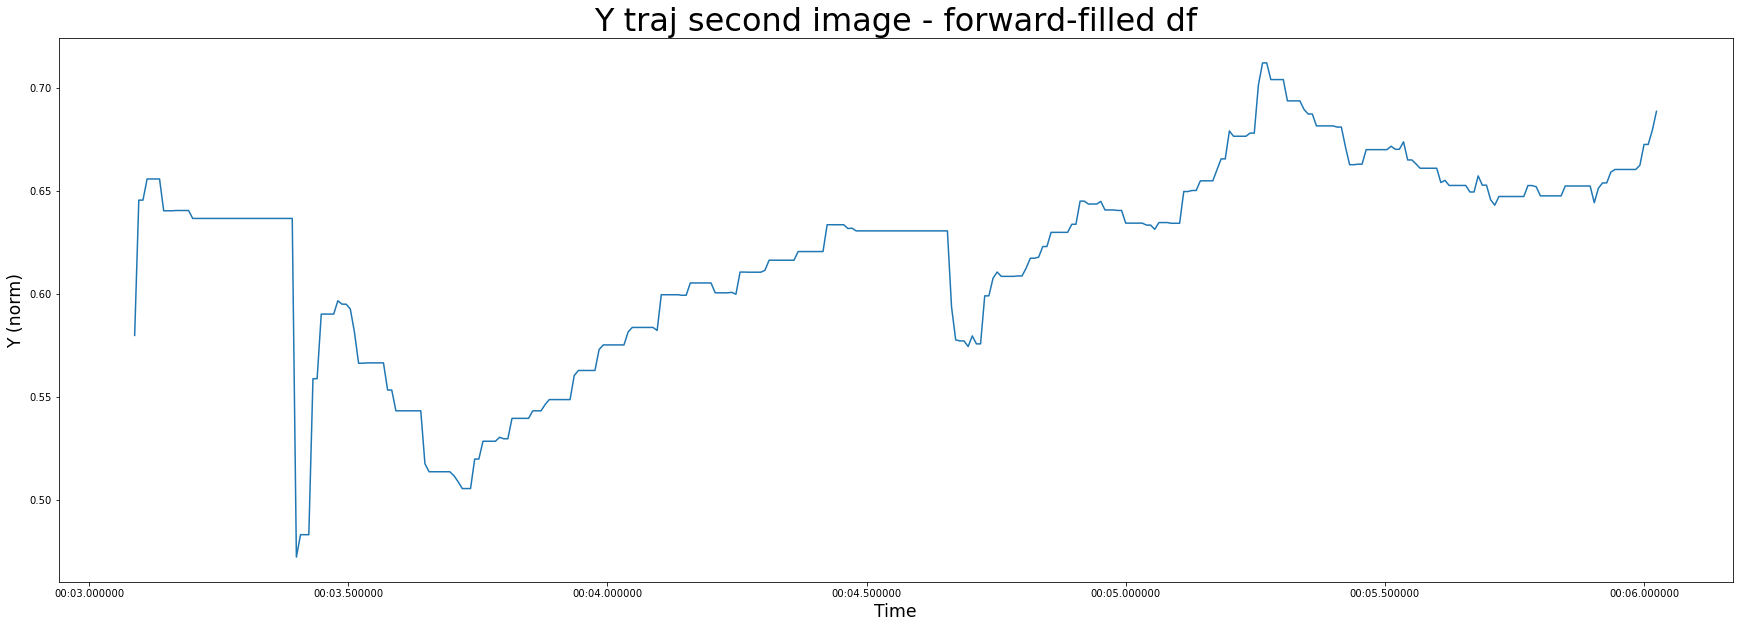

In [115]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ffill_slice.index,ffill_slice['norm_pos_y'])
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('Y traj second image - forward-filled df',fontsize=32)
plt.tick_params()
plt.show()

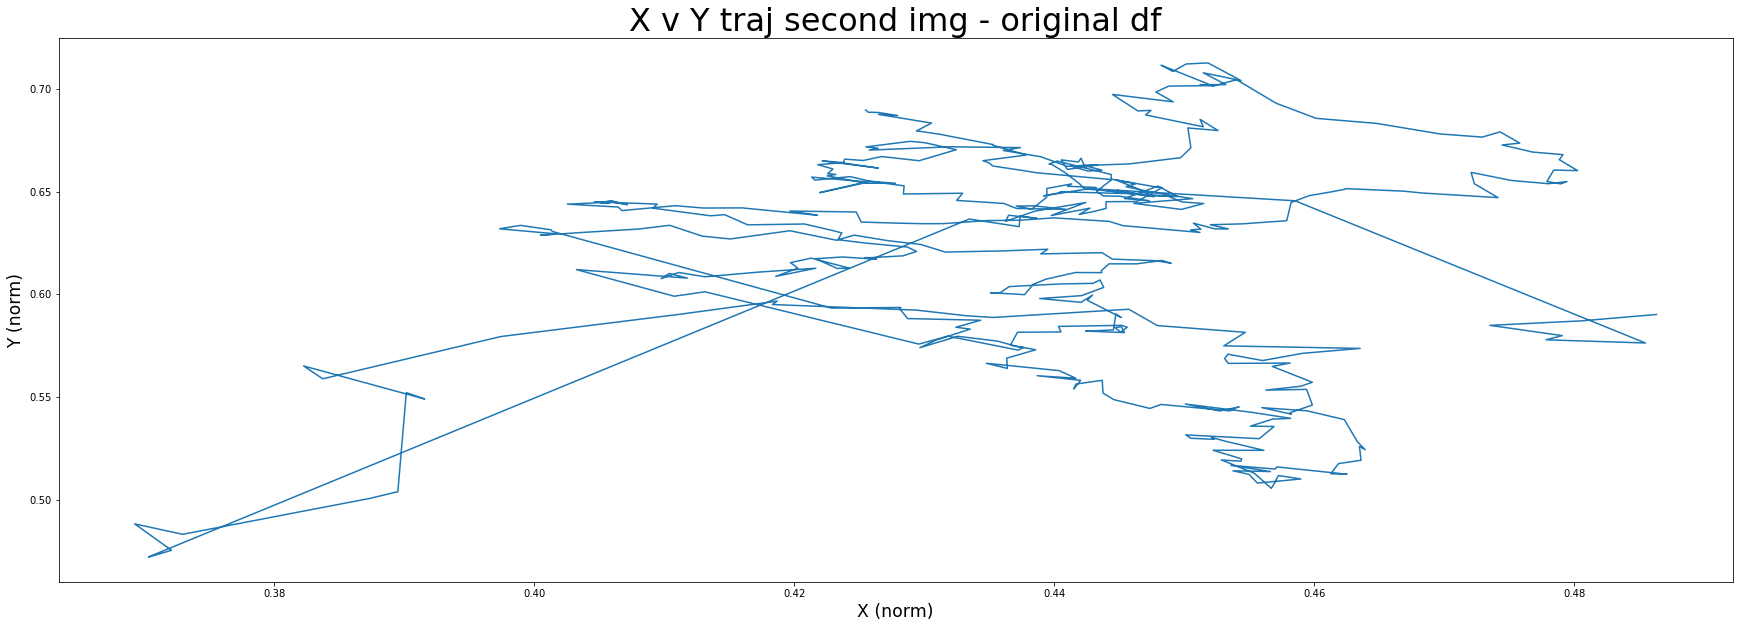

In [77]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(second_slice['norm_pos_x'],second_slice['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj second img - original df',fontsize=32)
plt.tick_params()
plt.show()

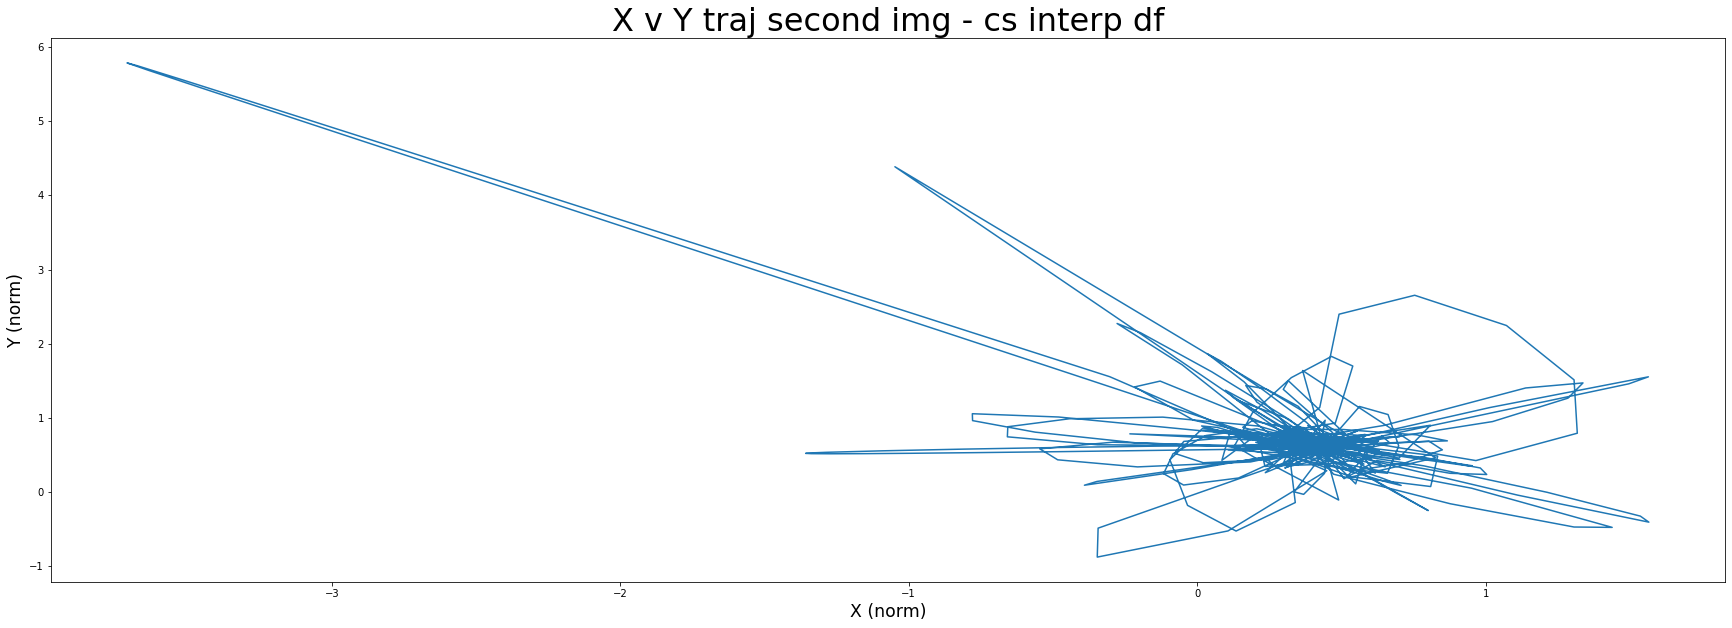

In [78]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(resecond_slice['norm_pos_x'],resecond_slice['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj second img - cs interp df',fontsize=32)
plt.tick_params()
plt.show()

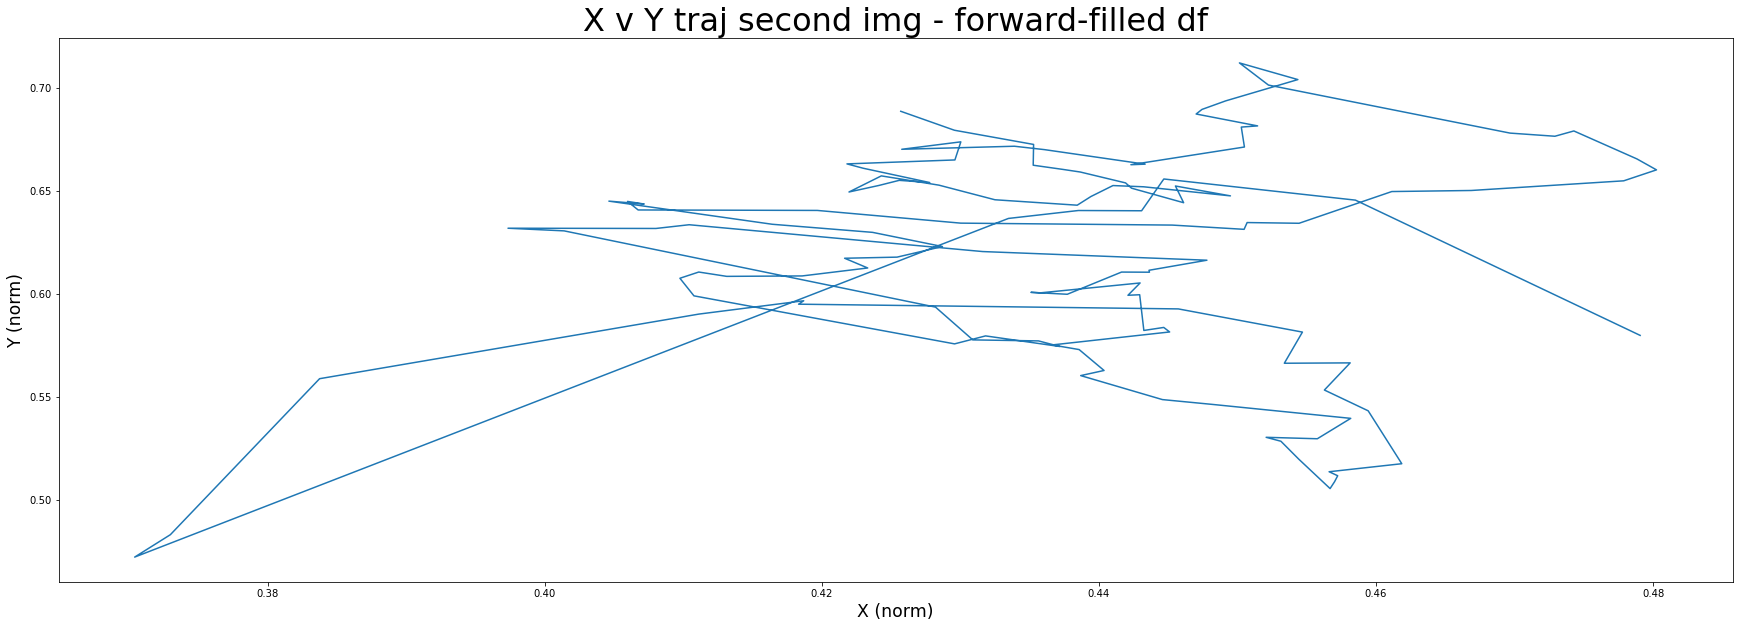

In [116]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ffill_slice['norm_pos_x'],ffill_slice['norm_pos_y'])
plt.xlabel('X (norm)',fontsize='xx-large')
plt.ylabel('Y (norm)',fontsize='xx-large')
plt.title('X v Y traj second img - forward-filled df',fontsize=32)
plt.tick_params()
plt.show()

-------------------------

Test zero-center

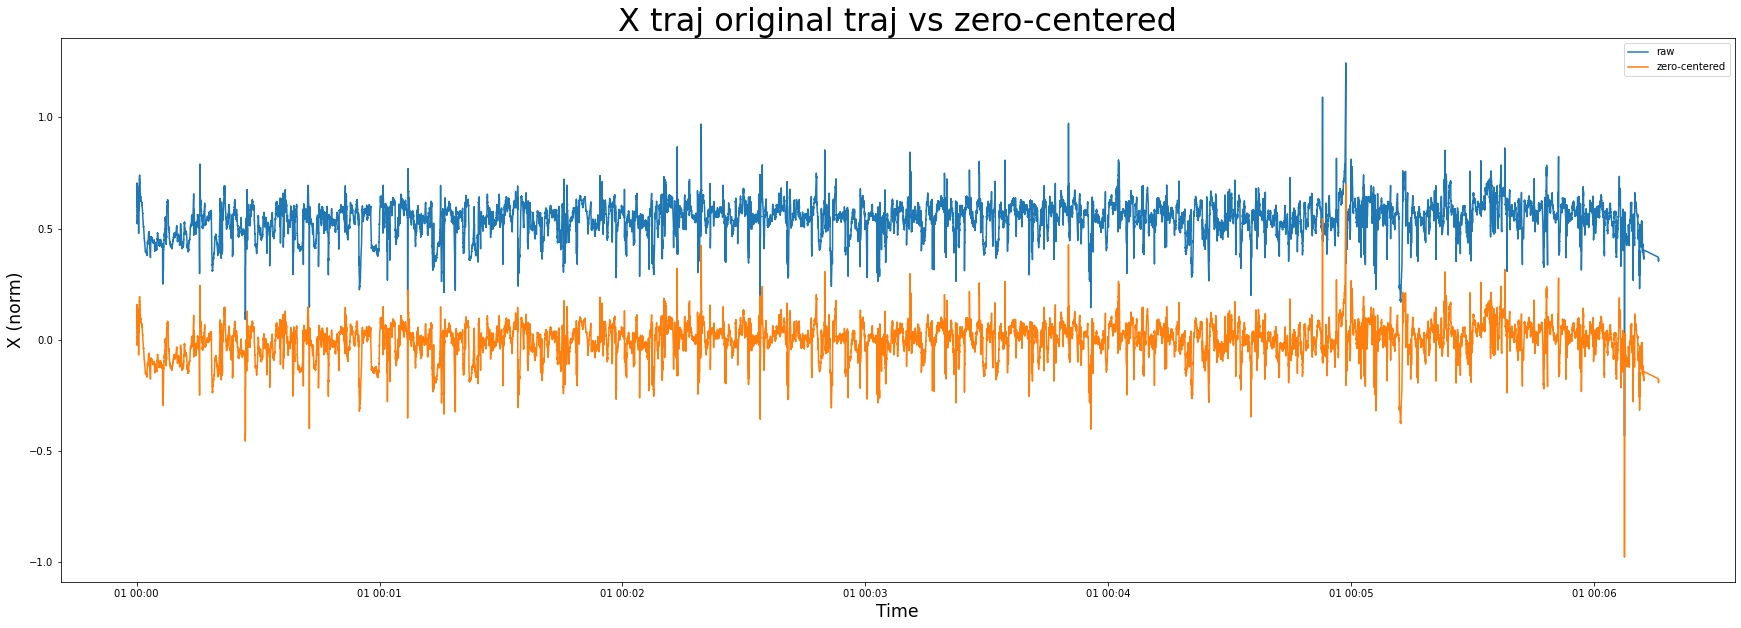

In [167]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ar_gaze_df['timedelta_dt'],ar_gaze_df['norm_pos_x'])
ax.plot(ar_gaze_df['timedelta_dt'],zero_center(ar_gaze_df['norm_pos_x']))
plt.xlabel('Timex',fontsize='xx-large')
plt.ylabel('X (norm)',fontsize='xx-large')
plt.title('X traj original traj vs zero-centered',fontsize=32)
ax.legend(['raw','zero-centered'])
plt.tick_params()
plt.show()

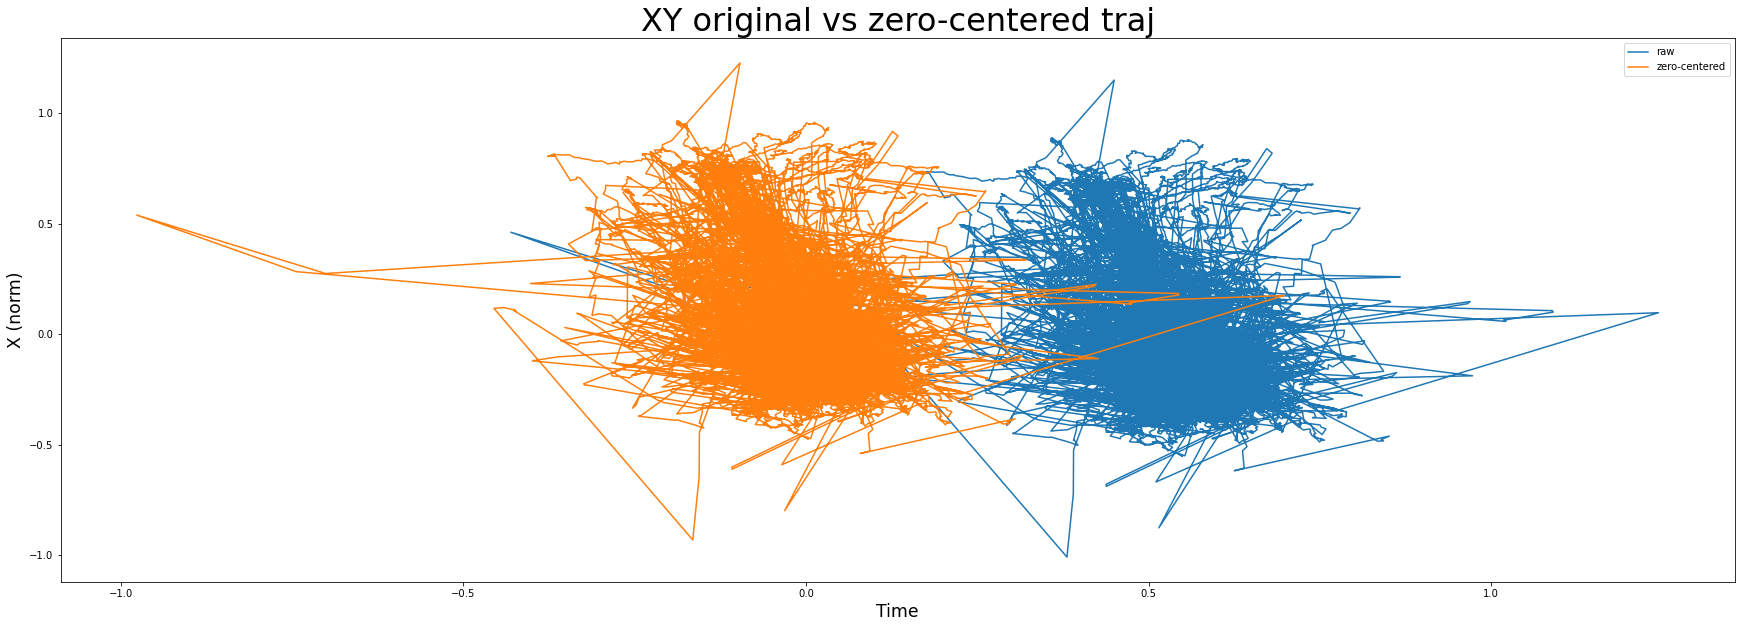

In [168]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ar_gaze_df['norm_pos_x'],ar_gaze_df['norm_pos_y'])
ax.plot(zero_center(ar_gaze_df['norm_pos_x']),zero_center(ar_gaze_df['norm_pos_y']))
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('X (norm)',fontsize='xx-large')
plt.title('XY original vs zero-centered traj',fontsize=32)
ax.legend(['raw','zero-centered'])
plt.tick_params()
plt.show()